<a href="https://colab.research.google.com/github/ces0008/Udacity-Datascience-ND/blob/master/Clustering_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [4]:
#!pip install yellowbrick
import warnings
warnings.filterwarnings('ignore')
#%config Completer.use_jedi = False
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import pandas as pd
import numpy as np
from datetime import datetime
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

# Prepare Data

In [8]:
url = 'https://drive.google.com/file/d/1d2udks8iRv-MpKDUMsbP9sA50sadcFt2/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
dataset = pd.read_csv('SampleData.csv')

#### check for nan values

In [9]:
dataset.dropna(inplace=True)

In [10]:
print(dataset.isnull().sum().sort_values(ascending=False))


CityId         0
GGDate         0
DateID         0
SalesAmount    0
CustomerID     0
FactSalesID    0
dtype: int64


In [11]:
dataset.duplicated().sum()

0

In [12]:
city_id = input(prompt='Enter a city number from 3, 4 or 9999 \n')
print(f'selected city is: {city_id}')

Enter a city number from 3, 4 or 9999 
4
selected city is: 4


In [13]:
def splitter(city_id):
    splitted_by_city = dataset[dataset['CityId'] == city_id ]
    splitted = splitted_by_city.drop(columns=['CityId'])
    return splitted

In [14]:
city_db = splitter(int(city_id))
print(city_db.shape)
city_db.info()

(8772, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8772 entries, 1 to 77227
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   FactSalesID  8772 non-null   int64 
 1   CustomerID   8772 non-null   int64 
 2   SalesAmount  8772 non-null   int64 
 3   DateID       8772 non-null   int64 
 4   GGDate       8772 non-null   object
dtypes: int64(4), object(1)
memory usage: 411.2+ KB


### Conver DateID column from integer to datetime format

In [15]:
city_db['DateID'] = pd.to_datetime(city_db['DateID'], format='%Y%m%d')

#### Create LRFM features and Megrge them altogether

(3403, 1)


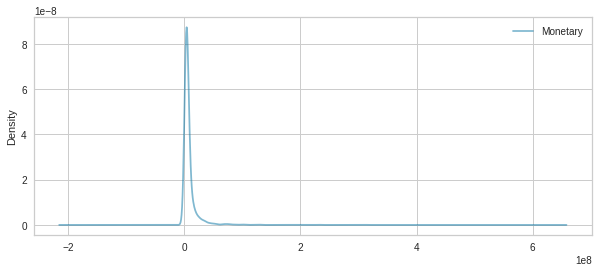

In [16]:
monetary_df = city_db.groupby(by='CustomerID')['FactSalesID'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.set_index('CustomerID', inplace=True)
monetary_df.plot(kind='kde', alpha = 0.5, figsize = (10,4))
print(monetary_df.shape)

In [17]:
city_db['DateID'].max()

Timestamp('2021-01-02 00:00:00')

In [18]:
# use last purchase date as current date
NOW = datetime(2021,1,2)
NOW

datetime.datetime(2021, 1, 2, 0, 0)

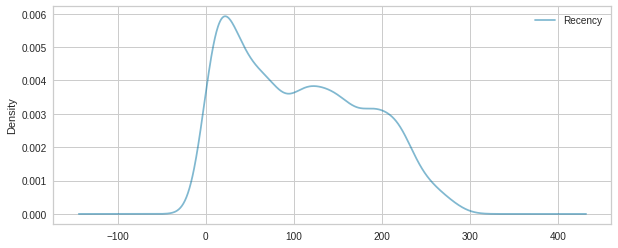

In [19]:
recency_df = city_db.groupby(by='CustomerID')['DateID'].max().reset_index()
recency_df.columns = ["CustomerID", "LastPurchaseDate"]
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (NOW - x).days)
recency_df.drop(columns=['LastPurchaseDate'], inplace=True)
recency_df.set_index('CustomerID', inplace=True)
recency_df.plot(kind='kde', alpha = 0.5, figsize = (10,4))

In [20]:
recency_df.describe()

,Recency
count,3403.000000
mean,105.850426
std,74.605131
min,0.000000
25%,37.000000
50%,99.000000
75%,165.000000
max,288.000000


In [21]:
length_df = city_db.groupby(by='CustomerID')['DateID'].min().reset_index()
length_df.columns = ['CustomerID', 'FirstPurchaseDate']
length_df['Length'] = length_df['FirstPurchaseDate'].apply(lambda x: (NOW - x).days)
length_df.drop(columns=['FirstPurchaseDate'], inplace=True)
length_df.set_index('CustomerID', inplace=True)
length_df.describe()

,Length
count,3403.000000
mean,134.944461
std,75.645213
min,0.000000
25%,70.000000
50%,139.000000
75%,198.000000
max,288.000000


In [22]:
frequency_df = city_db.groupby(by='CustomerID')['FactSalesID'].count().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.set_index('CustomerID', inplace=True)
frequency_df.describe()

,Frequency
count,3403.000000
mean,2.577726
std,5.215412
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,131.000000


In [23]:
lrfm_data = pd.concat([length_df, recency_df, frequency_df, monetary_df], axis=1)
lrfm_data.describe()

,Length,Recency,Frequency,Monetary
count,3403.000000,3403.000000,3403.000000,3.403000e+03
mean,134.944461,105.850426,2.577726,8.504674e+06
std,75.645213,74.605131,5.215412,1.735030e+07
min,0.000000,0.000000,1.000000,2.800528e+06
25%,70.000000,37.000000,1.000000,3.164986e+06
50%,139.000000,99.000000,1.000000,3.608030e+06
75%,198.000000,165.000000,2.000000,7.015516e+06
max,288.000000,288.000000,131.000000,4.398701e+08


In [24]:
#lrfm_data.reset_index()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec199df1d0>,
      dtype=object)

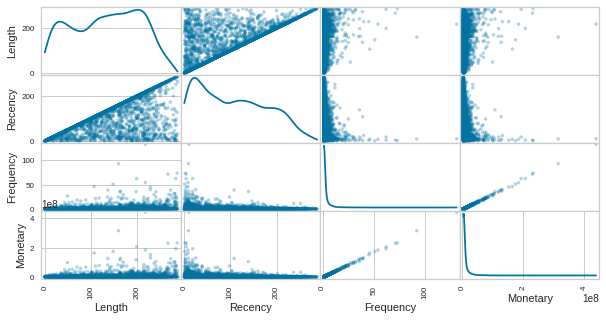

In [25]:
scatter_matrix(lrfm_data, alpha = 0.3, figsize = (10,5), diagonal = 'kde')

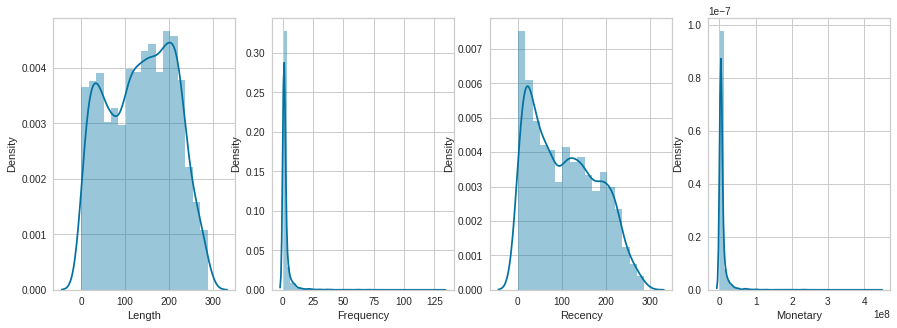

In [26]:
f, ax = plt.subplots(figsize=(15,5))

plt.subplot(1, 4, 1)
sns.distplot(lrfm_data['Length'])

plt.subplot(1, 4, 2)
sns.distplot(lrfm_data['Frequency'])

plt.subplot(1, 4, 3)
sns.distplot(lrfm_data['Recency'])

plt.subplot(1, 4, 4)
sns.distplot(lrfm_data['Monetary'])

plt.show()

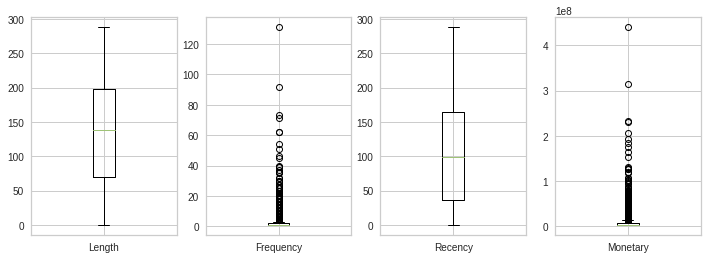

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.subplot(1,4,1)
plt.boxplot(lrfm_data['Length'], labels=['Length'])
plt.subplot(1,4,2)
plt.boxplot(lrfm_data['Frequency'], labels=['Frequency'])
plt.subplot(1,4,3)
plt.boxplot(lrfm_data['Recency'], labels=['Recency'])
plt.subplot(1,4,4)
plt.boxplot(lrfm_data['Monetary'], labels=['Monetary'])
plt.show()

### Removing Outliers

In [28]:
zscores = stats.zscore(lrfm_data)

lrfm_data_new = lrfm_data[(zscores < 3).all(axis=1)][['Length','Frequency','Monetary','Recency']]

print(f'Removed {lrfm_data.shape[0]-lrfm_data_new.shape[0]} rows containing abnormal values')

Removed 51 rows containing abnormal values


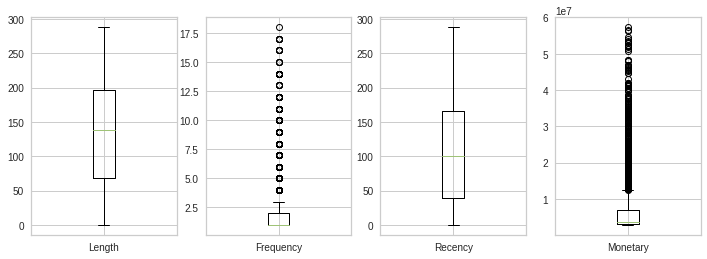

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.subplot(1,4,1)
plt.boxplot(lrfm_data_new['Length'], labels=['Length'])
plt.subplot(1,4,2)
plt.boxplot(lrfm_data_new['Frequency'], labels=['Frequency'])
plt.subplot(1,4,3)
plt.boxplot(lrfm_data_new['Recency'], labels=['Recency'])
plt.subplot(1,4,4)
plt.boxplot(lrfm_data_new['Monetary'], labels=['Monetary'])
plt.show()

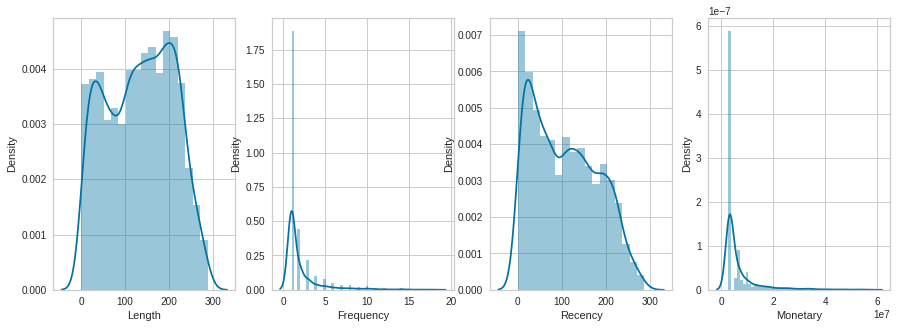

In [30]:
f, ax = plt.subplots(figsize=(15,5))

plt.subplot(1, 4, 1)
sns.distplot(lrfm_data_new['Length'])

plt.subplot(1, 4, 2)
sns.distplot(lrfm_data_new['Frequency'])

plt.subplot(1, 4, 3)
sns.distplot(lrfm_data_new['Recency'])

plt.subplot(1, 4, 4)
sns.distplot(lrfm_data_new['Monetary'])

plt.show()

#### Frequency and Monetary are highly right skewed. So its better to use log transform for them. Also Kmeans works better if the data is Standarzied

In [31]:
SS = StandardScaler()
lrfm_data_new[['Length']] = SS.fit_transform(lrfm_data_new[['Length']])
lrfm_data_new[['Recency']] = SS.fit_transform(lrfm_data_new[['Recency']])
lrfm_data_new['Frequency'] = np.log(lrfm_data_new['Frequency']+1)
lrfm_data_new['Monetary'] = np.log(lrfm_data_new['Monetary']+1)

lrfm_data_new[['Frequency']] = SS.fit_transform(lrfm_data_new[['Frequency']])
lrfm_data_new[['Monetary']] = SS.fit_transform(lrfm_data_new[['Monetary']])


# qt = QuantileTransformer(n_quantiles=100 )
# lrfm_data_new[['Length']] = qt.fit_transform(lrfm_data_new[['Length']])
# lrfm_data_new[['Recency']]  = qt.fit_transform(lrfm_data_new[['Recency']])
# lrfm_data_new[['Frequency']] = qt.fit_transform(lrfm_data_new[['Frequency']])
# lrfm_data_new[['Monetary']]  = qt.fit_transform(lrfm_data_new[['Monetary']])
# lrfm_data_new.describe()

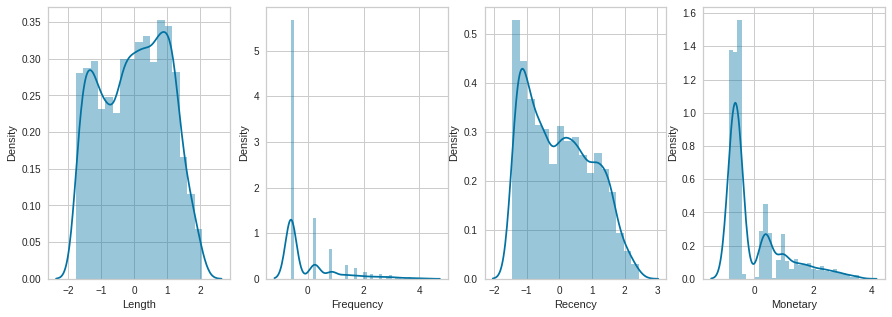

In [32]:
f, ax = plt.subplots(figsize=(15,5))

plt.subplot(1, 4, 1)
sns.distplot(lrfm_data_new['Length'])

plt.subplot(1, 4, 2)
sns.distplot(lrfm_data_new['Frequency'])

plt.subplot(1, 4, 3)
sns.distplot(lrfm_data_new['Recency'])

plt.subplot(1, 4, 4)
sns.distplot(lrfm_data_new['Monetary'])

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec199e1c18>,
      dtype=object)

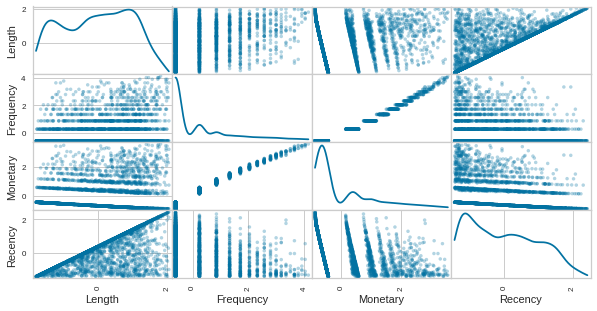

In [33]:
scatter_matrix(lrfm_data_new, alpha = 0.3, figsize = (10,5), diagonal = 'kde')

In [34]:
# sc = MinMaxScaler((0,1))
# scaled = sc.fit_transform(lrfmModel)
# lrfmModel_scaled = pd.DataFrame(data=scaled,index= lrfmModel.index,
#                                 columns=lrfmModel.columns)
# lrfmModel_scaled

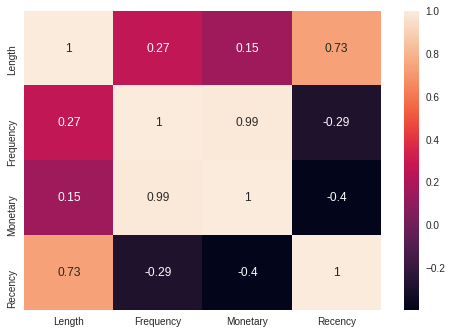

In [35]:
import seaborn as sns
sns.heatmap(lrfm_data_new.corr(),annot=True)

### It can be seen that Monetary has negative correlation with Recency. Length and Recency have positive correlation together. Also Monetary and Frequency has Positive correlation.

.

# Building Model

### Selecting optimal number of clusters

In [36]:
sse = [] # for Elbow method
sse_ = [] # for Silhouette analysis

list_k = list(range(2, 16))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(lrfm_data_new[['Length',  'Recency','Frequency','Monetary']])
    sse.append(km.inertia_)
    sse_.append([k, silhouette_score(lrfm_data_new[['Length', 'Recency','Frequency','Monetary']], km.labels_)])

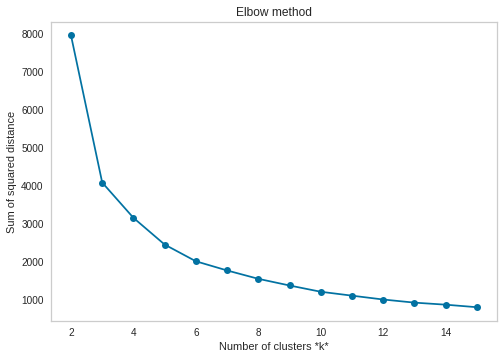

In [37]:
# Plot sse against k
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.grid()
plt.title('Elbow method')
plt.show()

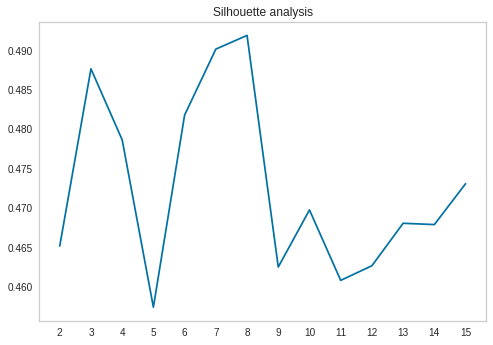

In [38]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.xticks(list(range(2, 16)))
plt.grid()
plt.title('Silhouette analysis')
plt.show()

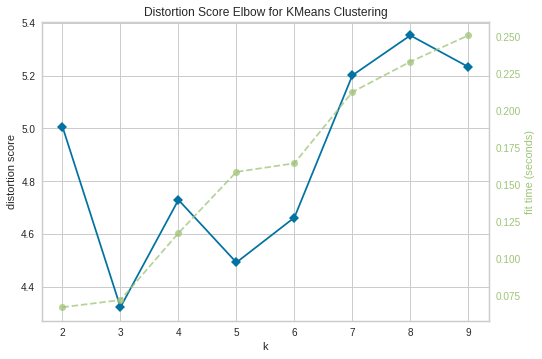

In [39]:
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k = (2,10))
visu.fit(lrfm_data_new)
visu.poof();


In [40]:
n_clusters = 3

In [41]:
model = KMeans(n_clusters)
label = model.fit_predict(lrfm_data_new)
client_level = pd.DataFrame(model.cluster_centers_, 
                            index=[f'Group{i+1}' for i in range(n_clusters)],
                           columns=['L', 'R','F','M']
                           )
l_labels = range(1,4)
r_labels = range(2,0,-1)
f_labels = range(1,5)
m_labels = range(1,5)
l_quartiles = pd.qcut(client_level['L'], q=3, labels = l_labels,duplicates='drop')
r_quartiles = pd.qcut(client_level['R'], q=2, labels = r_labels,duplicates='drop')
f_quartiles = pd.qcut(client_level['F'], q=4, labels = f_labels,duplicates='drop')
m_quartiles = pd.qcut(client_level['M'], q=4, labels = m_labels,duplicates='drop')
client_level = client_level.assign(L=l_quartiles, R=r_quartiles,
                                   F=f_quartiles, M=m_quartiles)
                                   #F=f_quartiles, M=m_quartiles

# Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['L']) + str(x['R']) + str(x['F']) + str(x['M'])  
client_level['LRFM_Segment'] = client_level.apply(add_rfm,axis=1 )
client_level['LRFM_Score'] = client_level[['L','R','F','M']].sum(axis=1)

client_level.head(6)

,L,R,F,M,LRFM_Segment,LRFM_Score
Group1,1,2,2,1,1221,6
Group2,3,2,1,4,3214,10
Group3,2,1,4,2,2142,9


In [42]:
def plot_kmeans(df, y_kmeans, centers):
    """docstring for plotKMeans
    this function plots the result of a KMeans training
    input:
        df: dataframe
        y_kmeans: kmeans prediction
        centers: cluster centroids"""
    
    # Setting up and plotting
    X = df.values
    sns.set(style='white', palette='muted', color_codes=True)
    fix, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='plasma')
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    ax.set_title('KMeans Applied', size=14)
    ax.set_xlabel(f'{df.columns[0]}', size=12, labelpad=5)
    ax.set_ylabel(f'{df.columns[1]}', size=12, labelpad=5)
#     format_spines(ax, right_border=False)
    plt.show()

In [43]:
label = model.predict(lrfm_data_new)

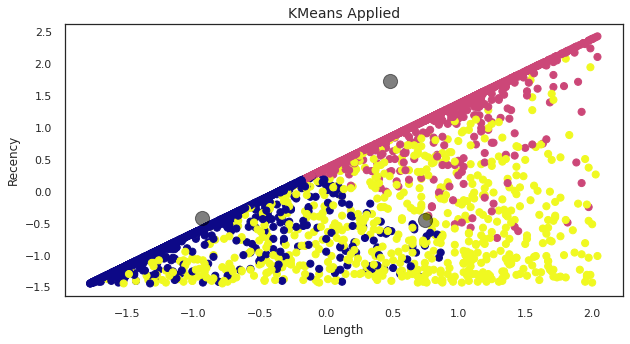

In [44]:
data = lrfm_data_new.copy()
data['label'] = label
lrfm_data_vis = data.loc[:, ['Length','Recency']]
plot_kmeans(lrfm_data_vis, label , model.cluster_centers_)

In [45]:
model.cluster_centers_

array([[-0.93251747, -0.41153488, -0.29912724, -0.69893436],
       [ 0.74484806, -0.43904091, -0.55527667,  1.0346142 ],
       [ 0.48478441,  1.72970608,  1.72348928, -0.57707791]])

In [46]:
data['L'] = data['label'].map(
        data.groupby('label')['Length'].mean() > data['Length'].mean()
    ).astype(int)
data['R'] = data['label'].map(
        data.groupby('label')['Recency'].mean() > data['Recency'].mean()
    ).astype(int)
data['F'] = data['label'].map(
        data.groupby('label')['Frequency'].mean() > data['Frequency'].mean()
    ).astype(int)
data['M'] = data['label'].map(
        data.groupby('label')['Monetary'].mean() > data['Monetary'].mean()
    ).astype(int)
data

,Length,Frequency,Monetary,Recency,label,L,R,F,M
CustomerID,,,,,,,,,
4973,0.678205,-0.607364,-0.754192,1.047395,1,1,1,0,0
4987,0.147097,-0.607364,-0.684765,0.509370,1,1,1,0,0
4998,1.554534,3.497221,3.093952,-1.158507,2,1,0,1,1
5528,1.142925,0.247899,0.378925,-0.956748,2,1,0,1,1
6194,1.209314,-0.607364,-0.818579,1.585420,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...
773240,-1.751616,-0.607364,-0.427216,-1.414069,0,0,0,0,0
775173,-1.764894,-0.607364,-0.424829,-1.427519,0,0,0,0,0
775232,-1.764894,-0.607364,-0.424771,-1.427519,0,0,0,0,0


### Number of Customers in Each Group

In [47]:
def cluster_mapper(r):
#     cluster = ''
#     t = df.iloc[0][['L','R','F','M']]
#     result = str(int(t[0])) + str(int(t[1])) + str(int(t[2])) + str(int(t[3]))
    if r == '1011':
        cluster = 'High Value Royal Customer'
        return cluster
    if r == '1001':
        cluster = 'Platinum Customer'
        return cluster
    if r == '1010':
        cluster = 'High Frequency Buying Customer'
        return cluster
    if r == '1111':
        cluster = 'Potential Loyal Customer'
        return cluster
    if r == '1101':
        cluster = 'Potential Consumption Customer'
        return cluster
    if r == '1110':
        cluster = 'Potential High Frequency Customer'
        return cluster
    if r == '0011':
        cluster = 'High Value New Customer'
        return cluster
    if r == '0001':
        cluster = 'Spender Promotion Customer'
        return cluster
    if r == '0010':
        cluster = 'Frequency Promotion Customer'
        return cluster
    if r == '0000':
        cluster = 'Uncertain New Customer'
        return cluster
    if r == '0111':
        cluster = 'High Value Lost Customer'
        return cluster
    if r == '0101':
        cluster = 'Consumption Lost Customer'
        return cluster
    if r == '0110':
        cluster = 'Frequency Lost Customer'
        return cluster
    if r == '0100':
        cluster = 'Uncertain Lost Customer'
        return cluster
    if r == '1000':
        cluster = 'Low Consumption Cost Customer'
        return cluster
    if r == '1100':
        cluster = 'High Consumption Cost Customer'
        return cluster
    else:
        return "There is an error"

In [48]:
def cluster_finder(df):
    test = df.copy()
    test = test[['label','L','R','F','M']]
    test.drop_duplicates(inplace=True)
    print(f'There are totally {test.shape[0]} clusters')
    for i in range(test.shape[0]):  
        row = test.iloc[i][['label','L','R','F','M']]
        result = str(int(row[1])) + str(int(row[2])) + str(int(row[3])) + str(int(row[4]))
        number_of_customer = df[df['label'] == row[0]].shape[0]
        print(f'{number_of_customer} customers are in the \"{cluster_mapper(result)}\" cluster')
    

In [49]:
cluster_finder(data)

There are totally 3 clusters
1305 customers are in the "High Consumption Cost Customer" cluster
661 customers are in the "High Value Royal Customer" cluster
1386 customers are in the "Uncertain New Customer" cluster


In [ ]:
model = KMeans(n_clusters=16,max_iter=300)
label = model.fit_predict(lrfm_data_new)
client_level16 = pd.DataFrame(model.cluster_centers_, 
                            index=['Cluster 1', 'Cluster 2', 'Cluster 3', 
                                   'Cluster 4','Cluster 5', 'Cluster 6',
                                   'Cluster 7', 'Cluster 8','Cluster 9', 
                                   'Cluster 10','Cluster 11', 'Cluster 12',
                                   'Cluster 13','Cluster 14', 'Cluster 15',
                                   'Cluster 16'],
                           columns=['L', 'R', 'F', 'M']
                             )
l_labels = range(1,3)
r_labels = range(2,0,-1)
f_labels = range(1,3)
m_labels = range(1,3)
l_quartiles = pd.qcut(client_level16['L'], q=2, labels = l_labels,duplicates='drop')
r_quartiles = pd.qcut(client_level16['R'], q=2, labels = r_labels)
f_quartiles = pd.qcut(client_level16['F'], q=2, labels = f_labels)
m_quartiles = pd.qcut(client_level16['M'], q=2, labels = m_labels)
client_level16 = client_level16.assign(L=l_quartiles, R=r_quartiles,
                                   F=f_quartiles, M=m_quartiles)

# Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['L']) + str(x['R']) + str(x['F']) + str(x['M'])
client_level16['LRFM_Segment'] = client_level16.apply(add_rfm,axis=1 )
client_level16['LRFM_Score'] = client_level16[['L','R','F','M']].sum(axis=1)

client_level16.head(16)

,L,R,F,M,LRFM_Segment,LRFM_Score
Cluster 1,1,2,1,1,1211,5
Cluster 2,1,2,1,2,1212,6
Cluster 3,2,1,2,1,2121,6
Cluster 4,2,2,1,2,2212,7
Cluster 5,1,2,1,2,1212,6
Cluster 6,2,2,1,2,2212,7
Cluster 7,2,1,2,2,2122,7
Cluster 8,1,1,2,1,1121,5
Cluster 9,1,2,1,1,1211,5
Cluster 10,1,2,2,1,1221,6


### It can be seen that KMeans Cannot perfectly assign different customer into desired clusters as some of clusters are the same in terms of statistical values.

#  Discusstion:

#### Another approach is to use LRFM analysis. We can use the mean or median parameters of each feature, then assign each customers by comparing each feature with mean or median of that feature in all data.

#### Each sample is whether higher than lower than mean or median. So it can be labeled as H or L. For example if it is {L:l, R:l, F:H, M:H}, it can be assinged to "High Value New Customer".


#### Another option is to run another Kmeans for each of 5 group to get all 16 clusters. So we can cluster each group by using kmeans with other two features. 

